# Simple Identify Sentiments problem

<img src="imgs/logo.jpg" width=80% style="float: center;"></img>
I simplify details of this tutorial, more details are in the last tutorial "bilstm+glove"

__*In this challenge, you are provided with tweet data to predict sentiment on electronic products of netizens.*__

Details of the problem statement and dataset could be refer to this page:  [here](https://datahack.analyticsvidhya.com/contest/linguipedia-codefest-natural-language-processing-1/)

If any reference is missing here, please tell me to update. 

__*References*__

- [deep.ai cources](https://www.coursera.org/specializations/deep-learning?)
- [NLP at IEST 2018: BiLSTM-Attention and LSTM-Attention via Soft
Voting in Emotion Classification](https://www.aclweb.org/anthology/W18-6226)
- [FEED-FORWARD NETWORKS WITH ATTENTION CAN
SOLVE SOME LONG-TERM MEMORY PROBLEMS](https://colinraffel.com/publications/iclr2016feed.pdf)
- [Overfitting in Machine Learning: What It Is and How to Prevent It](https://elitedatascience.com/overfitting-in-machine-learning#how-to-detect)

In [1]:
# Libraries used in Loading and catching a glimpse of dataset
import tensorflow as tf

import re
import json
import pandas as pd 
pd.set_option("display.max_colwidth", 150)
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
#Provided you are running IPython, 
#the %matplotlib inline will make your plot outputs appear and be stored within the notebook.

import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
# Libraries used in part of processing tweets
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tf.reset_default_graph
print(tf.__version__)

1.14.0


In [3]:
# Libraries used in modeling
from tensorflow.keras.layers import Bidirectional, GRU, Embedding, Dense, Dropout, Dot, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Lambda, Flatten,Layer

import matplotlib.pyplot as plt

### Global arguments

- `VOCAB_SIZE`: We take 10,000 word in our vocaburary, and add one more for the word 'unknown'. If we use LSTM/GRU, it will ignore the padding part. And for the vector of UNKNOWN, we can not just set 0 like the padding because UNKNOWN also contains some information.

https://github.com/keras-team/keras/issues/9637

In [4]:
DATA_PATH = 'dataset/train_2kmZucJ.csv'
# this is the pre-trained word-embedding path, remember to replace it with your own path
WV_PATH = 'pre_train_wordVec/glove.twitter/glove.twitter.27B.200d.txt'
POS = 0
NEG = 1
VOCAB_SIZE = 10000
MAXLEN = 80
EMBED_DIM = 200
REG_L2 = tf.keras.regularizers.l2(0.001)

### Figure

In [5]:
#plot the graphs for visualizing the training variation
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# 1. Loading and catching a glimpse of dataset

Most profane and vulgar terms in the tweets have been replaced with “$&@*#”. 
However, please note that the dataset still might contain text that may be considered profane, vulgar, or offensive.

In [6]:
train  = pd.read_csv(DATA_PATH)
train.shape

(7920, 3)

In [7]:
# list top 5 positive tweets in dataset
train[train['label'] == 0].head(5)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
6,7,0,Happy for us .. #instapic #instadaily #us #sony #xperia #xperiaZ https://instagram.com/p/z9qGfWlvj7/


In [8]:
# list top 5 negetive tweets in dataset
train[train['label'] == 1].head(5)

,id,label,tweet
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
5,6,1,iPhone software update fucked up my phone big time Stupid iPhones
10,11,1,hey #apple when you make a new ipod dont make it a new color or .2inches thinner make it not crash every five fuckin minite.
11,12,1,Ha! Not heavy machinery but it does what I need it to. @Apple really dropped the ball with that design. #drinkyourhaterade
12,13,1,Contemplating giving in to the iPhone bandwagon simply because #Cellcom has no new Androids #depressing #IDontWantTo


# 2. Data processing
## 2.1 Data cleaning

remove the redundant/helpless infors

In [9]:
def cleaning(tweets,isSample_predict):
    if isSample_predict:
        tweets = re.sub(r'http\S+', '', tweets)
        tweets = re.sub(r'@[A-Za-z0-9]+','',tweets)
        tweets = tweets.replace("[0-9]", " ")
        tweets = re.sub(r'#[A-Za-z0-9]+','',tweets)
        tweets = re.sub(r"[-()\"#/@$&;:<>{}`+=~|.!?,]", "", tweets)
    else:
        # remove URL
        tweets = tweets.apply(lambda x: re.sub(r'http\S+', '', x))
        # remove @user
        tweets = tweets.apply(lambda x: re.sub(r'@[A-Za-z0-9]+','',x))
        # remove numbers
        tweets = tweets.str.replace("[0-9]", " ")
        # remove whitespaces
        tweets = tweets.apply(lambda x:' '.join(x.split()))
        # remove hashtags
        tweets = tweets.apply(lambda x: re.sub(r'#[A-Za-z0-9]+','',x))
        # remove punctuation
        tweets = tweets.apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))

    return tweets 

In [10]:
train['tweet_clean'] = cleaning(train['tweet'],False)
#train.head(5)

## 2.2 dataset for Evalution the model
because I don't have enough dataset to do the evalution, so I decide to shuffle the train dataset and take some of them to evaluate my model

In [11]:
from sklearn.utils import shuffle

shuf_data = shuffle(train)
#shuf_data.head(5)

we could compare first 5 eval_datas with the original train data shown as above

then take about 3,000 lines used for evalution

In [12]:
x_eval = shuf_data['tweet_clean'][:3000]
y_eval = shuf_data['label'][:3000]
x_eval.shape,y_eval.shape

((3000,), (3000,))

## 2.3 Tokenizer
https://github.com/keras-team/keras/issues/9637

In [13]:
# Create padding sequence with a fix length
def token_pad(texts,isTrainDataset):
    
    num_words = VOCAB_SIZE
    if(not isTrainDataset and len(texts) < VOCAB_SIZE):
        num_words = len(texts)
    print(num_words)    
    # tokened
    tk = Tokenizer(num_words= num_words+1,oov_token='UNK')
    tk.fit_on_texts(texts)
    
    tk.word_index = {e:i for e,i in tk.word_index.items() if i <= num_words}
    tk.word_index[tk.oov_token] = num_words + 1
    
    seq_token = tk.texts_to_sequences(texts)
    
    #padding
    seq_pad = pad_sequences(seq_token, maxlen= MAXLEN, padding='post')
    
    return tk,seq_pad

In [14]:
tokenizer,seq_pad = token_pad(train['tweet_clean'],True)

10000


In [15]:
#print(tokenizer.word_index)

# 3. Modeling

## BiGRU + glove + Attention

### model draft
![model3_with_atten](imgs/model_biGRU_atten.jpg)


### attention layer mechanism

Because I don't think that the previous output from the output layer will influence the next result, So here I caculate the attention by using 'FEED-FORWARD ATTENTION' from this paper [click](https://colinraffel.com/publications/iclr2016feed.pdf)

<table>
<td> 
<img src="imgs/feed-forward.JPG" style="width:300;height:300px;">
</td> 
</table>
<caption><center> Figure:Schematic of our proposed “feed-forward” attention mechanism</center></caption>

Here are some properties of the model that you may notice: 

- There are one BiGURs in this model.The pre-attention Bi-GRU goes through $T$ time steps.

- The Bi-GRU produces a hidden state ${h_t}$ from one time step to the next. Here the attention-based models compute a “context” vector ${c_t}$ as the weighted mean of the state sequence by
$$context = \sum_{t = 1}^{T} \alpha_t h_t\tag{1}$$

- We use $h_t = [\overrightarrow{h_t}; \overleftarrow{h_t}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-GRU. 

- Uses a neural network with the activation `(tanh)`&`(relu)` to compute $e_t$, which is then passed through a softmax to compute $\alpha_{\langle t\rangle}$.
$$e_t = NN(h_t)$$

![alpha_equation](imgs/alpha.jpg)

Two steps:
1. Define the layer objects (as global variables for examples).
2. Call these objects when propagating the input.

Please check the Keras documentation to make sure you understand what these layers are: [Dense()](https://keras.io/layers/core/#dense), [Activation()](https://keras.io/layers/core/#activation), [Dot()](https://keras.io/layers/merge/#dot).


In [16]:
# Defined shared layers as global variables
densor1 = Dense(100, activation = "tanh",name="inter_energies")
densor2 = Dense(1, activation = "relu",name="final_energies")
activator = Activation('softmax', name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

W0704 13:14:15.039459  9852 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
# GRADED FUNCTION: one_step_attention

def attention(h):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "h" of the Bi-LSTM.
    
    Arguments:
    h -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    
    Returns:
    context -- context vector, input of the next (post-attetion) BiLSTM cell
    """
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e.
    e = densor1(h)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,h])
    ### END CODE HERE ###
    
    return context

### Extract word embeddings from the Glove

In [18]:
glove = dict()
f = open(WV_PATH, encoding='utf8')

for line in f:
    values = line.split()
    # char
    word = values[0]
    # vector value from index 1
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()
len(glove)

1193514

### Create a weight matrix

In [19]:
tokenizer.num_words

10001

In [20]:
embedding_matrix = np.zeros((tokenizer.num_words+1, EMBED_DIM))
for word, index in tokenizer.word_index.items():
    if index > tokenizer.num_words+2:
        break
    else:
        embedding_vector = glove.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

#embedding_matrix[:3]

During the embedding generating,  we set trainable=False to prevent the weights from being updated during training
more detail about using pre-trained word embeddings in a Keras model could refer to [here](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

In [21]:
len(embedding_matrix)

10002

By defaut I use (`adagrad`), and (`binary_crossentropy`)
- The problem is a logistic regression one rathen than a linear one.

In [22]:
def train_model(model,batch_sz):
    # Configures the model for training.
    model.compile(loss='binary_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])
    # Train...
    history = model.fit(seq_pad,
                   train['label'],
                   batch_sz,
                   10,
                   2,
                   validation_split=0.2)
    
    return history

We have prepared in advance our attention layer, embedding glove weights, configures of the model, now we could begin to build our model.

In [23]:
embedding_layer = Embedding(tokenizer.num_words+1, 
                            EMBED_DIM,
                            input_length = MAXLEN,
                            mask_zero=True,
                            weights=[embedding_matrix],
                            trainable=False,
                            name="embedding"
                           )

tweets_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(tweets_input)

hidden = Bidirectional(
    GRU(200, 
        return_sequences=True,
        recurrent_dropout=0.2,
        activity_regularizer=REG_L2),
    name="BiGRU"
)(embedded_sequences)

context = attention(hidden)
dense_1 = Dense(100,activation='tanh',name="compute_context")(context)
dense_2 = Flatten()(Dense(1, activation='sigmoid',name="prediction")(dense_1))

model_atten = Model(tweets_input, dense_2)
#model_atten.name = "BiGRU_atten"

model_atten.summary()

W0704 13:15:41.512052  9852 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0704 13:15:41.606715  9852 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0704 13:15:41.607713  9852 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling Orthogonal.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 200)      2000400     input_1[0][0]                    
__________________________________________________________________________________________________
BiGRU (Bidirectional)           (None, 80, 400)      481200      embedding[0][0]                  
__________________________________________________________________________________________________
inter_energies (Dense)          (None, 80, 100)      40100       BiGRU[0][0]                      
______________________________________________________________________________________________

In [24]:
history = train_model(model_atten,512)

Train on 6336 samples, validate on 1584 samples


W0704 13:15:43.326430  9852 deprecation.py:506] From C:\Users\xiaoin.lu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/10
6336/6336 - 30s - loss: 0.4667 - acc: 0.7842 - val_loss: 0.3085 - val_acc: 0.8756
Epoch 2/10
6336/6336 - 31s - loss: 0.3156 - acc: 0.8701 - val_loss: 0.2878 - val_acc: 0.8876
Epoch 3/10
6336/6336 - 34s - loss: 0.2898 - acc: 0.8823 - val_loss: 0.2862 - val_acc: 0.8807
Epoch 4/10
6336/6336 - 37s - loss: 0.2841 - acc: 0.8842 - val_loss: 0.2783 - val_acc: 0.8832
Epoch 5/10
6336/6336 - 37s - loss: 0.2728 - acc: 0.8911 - val_loss: 0.2736 - val_acc: 0.8883
Epoch 6/10
6336/6336 - 39s - loss: 0.2715 - acc: 0.8944 - val_loss: 0.2706 - val_acc: 0.8889
Epoch 7/10
6336/6336 - 39s - loss: 0.2638 - acc: 0.8957 - val_loss: 0.2662 - val_acc: 0.8914
Epoch 8/10
6336/6336 - 40s - loss: 0.2615 - acc: 0.8966 - val_loss: 0.2673 - val_acc: 0.8895
Epoch 9/10
6336/6336 - 41s - loss: 0.2593 - acc: 0.8966 - val_loss: 0.2693 - val_acc: 0.8864
Epoch 10/10
6336/6336 - 41s - loss: 0.2566 - acc: 0.8993 - val_loss: 0.2650 - val_acc: 0.8939


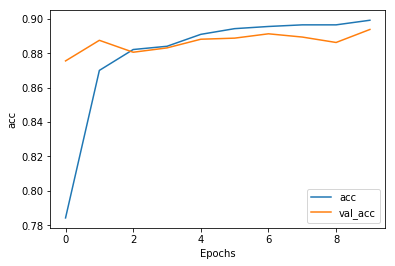

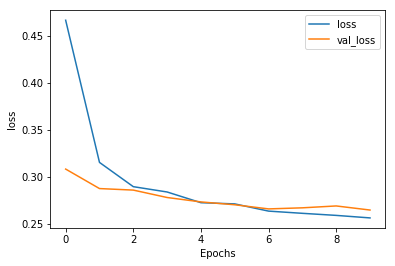

(None, None)

In [25]:
plot_graphs(history, 'acc'),plot_graphs(history, 'loss')

In [26]:
_,eval_pad = token_pad(x_eval,False)
# Evaluate the model on the test data using `evaluate`
test_loss, test_acc = model_atten.evaluate(eval_pad,y_eval,128)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

3000
3000/3000 [==============================] - 5s 2ms/sample - loss: 0.4944 - acc: 0.7580
Test Loss: 0.49440689039230346
Test Accuracy: 0.7580000162124634


https://github.com/allenai/bilm-tf/issues/73

In [27]:
# prediction
def sample_predict(tweet,x_model):
    predictions = ''
    clean_sent = cleaning(tweet,True)
    # noted that parameter [clean_sent], if use tokenizer.texts_to_sequences(clean_sent)
    # the token will give different vector to each word, not a vector for one sentence!
    token_tweet = tokenizer.texts_to_sequences([clean_sent])
    token_tweet_pad = pad_sequences(token_tweet,maxlen=MAXLEN,padding='post')
    result = x_model.predict(token_tweet_pad)
    
    if result < 0.5:
        predictions = 'positive'
    else:
        predictions = 'negative'

    return tweet,result,predictions

In [28]:
sample_neg_1 = 'I waited for more than half of an hour for their stupid support!'
sample_neg = 'stupid'
sample_pos = 'I love this!'

In [29]:
pred_pos = sample_predict(sample_pos,model_atten)
pred_neg = sample_predict(sample_neg,model_atten)
pred_neg_1 = sample_predict(sample_neg_1,model_atten)
print(f'{pred_pos}\n{pred_neg}\n{pred_neg_1}')

('I love this!', array([[0.0107442]], dtype=float32), 'positive')
('stupid', array([[0.53377867]], dtype=float32), 'negative')
('I waited for more than half of an hour for their stupid support!', array([[0.635351]], dtype=float32), 'negative')
